In [1]:
import joblib
import numpy as np
import csv
import os
import json
import librosa
import IPython.display as ipd
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks
from sklearn.preprocessing import normalize

import matplotlib

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.9, window=np.hanning): # was 0.5
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=22050, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(binsize=2**10, plotpath=None, colormap="jet", srr = 22050, sam = None):
    samplerate, samples = srr, sam

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    
    fig = plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.savefig("test.png", bbox_inches='tight', pad_inches = 0)
        plt.show()

    plt.clf()

    return ims

In [2]:


""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.9, window=np.hanning): # was 0.5
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=22050, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft2(binsize=2**10, plotpath=None, colormap="jet", srr = 22050, sam = None):
    samplerate, samples = srr, sam

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    print("timebins: ", timebins)
    print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    
    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

    plt.clf()

    return ims

In [3]:
csv_path = '../2020/dataset_management/csv/1sr_April_pattern_matching_ROIs_200331.csv'

In [4]:
import pandas as pd
pd.read_csv(csv_path,index_col=None)

,filename,recording,site,device,year,month,day,hour,min,species,birdcode,commonname,songtype,x1,x2,y1,y2,score,vote,type
0,s2llg007_170627_2017-06-29_08-20.wav,s2l07_170627_pepperwood_1422-2017-06-29_08-20....,s2llg007_170627,lg,2017,6,29,8,20,Melanerpes formicivorus,ACWO,Acorn Woodpecker,Simple Call,16.637098,16.822857,1119.726562,4048.242188,0.481261,present,Expert
1,s2llg007_170430_2017-05-01_07-50.wav,s2l07_170430_pepperwood_1300-2017-05-01_07-50....,s2llg007_170430,lg,2017,5,1,7,50,Melanerpes formicivorus,ACWO,Acorn Woodpecker,Simple Call,46.312200,46.497959,1119.726562,4048.242188,0.435504,not present,Expert
2,s2llg006_170708_2017-07-12_05-40.wav,s2l06_170708_pepperwood_1422-2017-07-12_05-40....,s2llg006_170708,lg,2017,7,12,5,40,Melanerpes formicivorus,ACWO,Acorn Woodpecker,Simple Call,6.124263,6.310023,1119.726562,4048.242188,0.376253,present,Expert
3,s2llg010_170509_2017-05-12_07-10.wav,s2l_170509_028390028_1433-2017-05-12_07-10.flac,s2llg010_170509,lg,2017,5,12,7,10,Melanerpes formicivorus,ACWO,Acorn Woodpecker,Simple Call,29.396463,29.582222,1119.726562,4048.242188,0.625227,not present,Expert
4,s2llg004_170804_2017-08-05_09-10.wav,tbc3_longterm_170804_pepperwood_1422-2017-08-0...,s2llg004_170804,lg,2017,8,5,9,10,Melanerpes formicivorus,ACWO,Acorn Woodpecker,Simple Call,0.876553,1.062313,1119.726562,4048.242188,0.367422,present,Expert
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61798,s2lam007_180624_2018-06-30_05-30.wav,s2lam07_180624_pepperwood-2018-06-30_05-30.flac,s2lam007_180624,am,2018,6,30,5,30,Chamaea fasciata,WREN,Wrentit,Common Song,33.703764,36.118639,1636.523438,3617.578125,0.288504,present,Non-Consensus to Expert
61799,s2lam007_180624_2018-06-30_06-00.wav,s2lam07_180624_pepperwood-2018-06-30_06-00.flac,s2lam007_180624,am,2018,6,30,6,0,Chamaea fasciata,WREN,Wrentit,Common Song,5.073560,7.488435,1636.523438,3617.578125,0.345176,present,Non-Consensus to Expert
61800,s2lam009_180707_2018-07-14_06-20.wav,s2lam09_180707_SeaRanch-2018-07-14_06-20.flac,s2lam009_180707,am,2018,7,14,6,20,Chamaea fasciata,WREN,Wrentit,Common Song,44.919002,47.333878,1636.523438,3617.578125,0.242076,present,Non-Consensus to Expert
61801,s2lam009_180707_2018-07-08_06-00.wav,s2lam09_180707_SeaRanch-2018-07-08_06-00.flac,s2lam009_180707,am,2018,7,8,6,0,Chamaea fasciata,WREN,Wrentit,Common Song,34.829932,37.244807,1636.523438,3617.578125,0.228876,present,Non-Consensus to Expert


In [5]:
import csv
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

sp_names = []
fir_app = "birdcode"

with open(csv_path,'rt')as f:
    data = csv.reader(f)
    for row in data:
        #print(row[10])
        if(row[10] != fir_app):
            sp_names.append(row[10])
            fir_app = row[10]

print(sp_names)

# becasue there were duplicates!!
mylist = list(dict.fromkeys(sp_names))
print(mylist)
print(len(mylist))
sp_names = mylist

['ACWO', 'AMRO', 'BEWR', 'BGGN', 'BHGR', 'BTPI', 'CAQU', 'CASJ', 'CAVI', 'CBCH', 'DEJU', 'NOFL', 'OCWA', 'PIWO', 'RWBL', 'SPTO', 'STJA', 'WAVI', 'WBNU', 'WEME', 'WITU', 'WIWA', 'WREN', 'BGGN', 'BTPI', 'CASJ', 'DEJU', 'WCSP', 'WETA', 'WIWA', 'ACWO', 'AMRO', 'BEWR', 'BGGN', 'BHGR', 'BRCR', 'BTYW', 'CAQU', 'CASJ', 'CAVI', 'CBCH', 'CORA', 'DEJU', 'MODO', 'NOFL', 'NUWO', 'OCWA', 'PIWO', 'PSFL', 'RSHA', 'RWBL', 'SOSP', 'SPTO', 'STJA', 'WAVI', 'WBNU', 'WEME', 'WITU', 'WIWA', 'WREN', 'AMRO', 'BHGR', 'BRCR', 'BTYW', 'CASJ', 'CAVI', 'CBCH', 'DEJU', 'OCWA', 'PIWO', 'PSFL', 'RSHA', 'RWBL', 'WBNU', 'WIWA', 'WREN']
['ACWO', 'AMRO', 'BEWR', 'BGGN', 'BHGR', 'BTPI', 'CAQU', 'CASJ', 'CAVI', 'CBCH', 'DEJU', 'NOFL', 'OCWA', 'PIWO', 'RWBL', 'SPTO', 'STJA', 'WAVI', 'WBNU', 'WEME', 'WITU', 'WIWA', 'WREN', 'WCSP', 'WETA', 'BRCR', 'BTYW', 'CORA', 'MODO', 'NUWO', 'PSFL', 'RSHA', 'SOSP']
33


In [6]:
sp_names

['ACWO',
 'AMRO',
 'BEWR',
 'BGGN',
 'BHGR',
 'BTPI',
 'CAQU',
 'CASJ',
 'CAVI',
 'CBCH',
 'DEJU',
 'NOFL',
 'OCWA',
 'PIWO',
 'RWBL',
 'SPTO',
 'STJA',
 'WAVI',
 'WBNU',
 'WEME',
 'WITU',
 'WIWA',
 'WREN',
 'WCSP',
 'WETA',
 'BRCR',
 'BTYW',
 'CORA',
 'MODO',
 'NUWO',
 'PSFL',
 'RSHA',
 'SOSP']

In [7]:
roi_list = []
for i in range(len(sp_names)):
    roi_cnt = 0
    bird = sp_names[i]
    highest_dur = 0
    dur =0 
    with open(csv_path,'rt')as f:
        data = csv.reader(f)
        for row in data:
            #print(row[10])
            if(row[10]==bird and row[18] =='present' and row[0] != 'NA'):
                #print(row[18])
                roi_cnt = roi_cnt+1
                dur = dur + (np.float16(row[14])-np.float16(row[13]))
                if ((np.float16(row[14]) - np.float16(row[13])) > highest_dur):
                    highest_dur = np.float16(row[14]) - np.float16(row[13])
    if(roi_cnt!=0)            :
        print(roi_cnt,'ROIs for',sp_names[i])
        print("Avg. duration: dur:",dur/roi_cnt)
        print("Highest duration:",highest_dur)
        print('-'*50)
        roi_list.append([roi_cnt,sp_names[i]])

177 ROIs for ACWO
Avg. duration: dur: 0.185863430217161
Highest duration: 0.1875
--------------------------------------------------
222 ROIs for AMRO
Avg. duration: dur: 1.7335985888231982
Highest duration: 3.5
--------------------------------------------------
300 ROIs for BEWR
Avg. duration: dur: 0.6650569661458333
Highest duration: 0.6875
--------------------------------------------------
49 ROIs for BGGN
Avg. duration: dur: 0.5056052694515306
Highest duration: 0.578
--------------------------------------------------
286 ROIs for BHGR
Avg. duration: dur: 0.5334233637456294
Highest duration: 0.5625
--------------------------------------------------
115 ROIs for BTPI
Avg. duration: dur: 0.6095448369565217
Highest duration: 0.625
--------------------------------------------------
1053 ROIs for CAQU
Avg. duration: dur: 0.3216238574311491
Highest duration: 0.375
--------------------------------------------------
573 ROIs for CASJ
Avg. duration: dur: 1.1646624127399652
Highest duration: 1

In [8]:
(roi_list)
roi_sum = 0
indx = 0
total_roi_w_cutoff = 0
bird_name_lst = []
cutoff_sp_name = []
cutoff = 400# th nuo. or ROIs should at least be these many


for i in range(len(roi_list)):
    roi_sum = roi_sum + roi_list[i][0]
    
    if(roi_list[i][0] >=cutoff):
        indx+=1
        print(indx, roi_list[i])
        cutoff_sp_name.append(roi_list[i])
        total_roi_w_cutoff += roi_list[i][0]
        bird_name_lst.append(roi_list[i])
print("ROI_SUM with cutoff",total_roi_w_cutoff)
print("ROI_SUM for all birds",roi_sum)


1 [1053, 'CAQU']
2 [573, 'CASJ']
3 [493, 'CBCH']
4 [1319, 'DEJU']
5 [980, 'OCWA']
6 [457, 'SPTO']
7 [623, 'STJA']
8 [448, 'WAVI']
9 [441, 'WITU']
10 [435, 'WIWA']
11 [590, 'WREN']
12 [492, 'WCSP']
13 [478, 'MODO']
14 [2969, 'PSFL']
ROI_SUM with cutoff 11351
ROI_SUM for all birds 13724


In [10]:
(cutoff_sp_name)
for i in range(len(cutoff_sp_name)):
    print(cutoff_sp_name[i][1])


CAQU
CASJ
CBCH
DEJU
OCWA
SPTO
STJA
WAVI
WITU
WIWA
WREN
WCSP
MODO
PSFL
Done


In [13]:
import os
import joblib 

for iii in range(len(cutoff_sp_name))[10:]: # added [:1] here to test code below
    print(cutoff_sp_name[iii][1])
    bird_name = cutoff_sp_name[iii][1] # bird of interest
    roi_ACWO = []
    dir_path = '/media/second/dist_data/DistributionData/'
    alt_dir_path = '/media/first/S2L_new_files/'
    second_alt_dir_path = '/media/first/S2L_new_files2/'
    sr = 22050
    roi_cnt = 0

    with open(csv_path,'rt')as f:
        data = csv.reader(f)
        for n_row, row in enumerate(data):

            if(row[10] == bird_name and row[18] =='present' and row[0] != 'NA'):
                print('-'*20)
                roi_cnt +=1
                print(roi_cnt, row[10],"and file is:",row[0])
                st = round((float(row[13]))*sr)
                en = round((float(row[14]))*sr)
                top = float(row[15])
                botm = float(row[16])
                
                print("Start sample:", st,"||  End sample:", en)

                #break
                try:
                    print("Loading the file name in librosa now... ")
                    x, sr = librosa.load(dir_path+row[0])
                    print("Total audio legth",x.shape[0]/sr,"Sample rate" ,sr,"on",row[3])
                    #roi_cnt +=1
                    pth_ = dir_path+row[0]

                except:
                    print("Main Dir doesn't have it... ")

                    try:
                        print("**In EXCEPT** Loading the file name in librosa now... ")
                        x, sr = librosa.load(alt_dir_path+row[0])
                        print("Total audio legth",x.shape[0]/sr,"Sample rate" ,sr,"on",row[3])
                        #roi_cnt +=1
                        pth_ = alt_dir_path+row[0]
                    except:
                        print("First updates S2L dir has it... ")
                        try:
                            print("**In EXCEPT** Loading the file name in librosa now... ")
                            x, sr = librosa.load(second_alt_dir_path+row[0])
                            print("Total audio legth",x.shape[0]/sr,"Sample rate" ,sr,"on",row[3])
                            pth_ = second_alt_dir_path+row[0]

                        except Exception as error:
                            print('***********************Caught this error: ' + repr(error))
                            print('WAWAW'*1000)
                            break
                roi_ACWO.append((x[st:en],pth_,st,en, top, botm))
                
    jl_file_dmp = os.path.join('/media/first/pickled_s2l_2020/2_ext_april17/','ext_' + cutoff_sp_name[iii][1] + '_3_Mar2020.pkl')
    joblib.dump(roi_ACWO,jl_file_dmp)
    
    print("Saved at",jl_file_dmp)

WREN
--------------------
1 WREN and file is: s2lam049_190505_2019-05-07_08-10.wav
Start sample: 598702 ||  End sample: 649975
Loading the file name in librosa now... 
Total audio legth 60.0 Sample rate 22050 on am
--------------------
2 WREN and file is: s2lam046_190505_2019-05-11_07-10.wav
Start sample: 980078 ||  End sample: 1031352
Loading the file name in librosa now... 
Total audio legth 60.0 Sample rate 22050 on am
--------------------
3 WREN and file is: s2lam049_190505_2019-05-07_08-30.wav
Start sample: 458758 ||  End sample: 510031
Loading the file name in librosa now... 
Total audio legth 60.0 Sample rate 22050 on am
--------------------
4 WREN and file is: s2lam037_190413_2019-04-14_09-00.wav
Start sample: 998071 ||  End sample: 1049345
Loading the file name in librosa now... 
Total audio legth 60.0 Sample rate 22050 on am
--------------------
5 WREN and file is: s2lam015_190427_2019-04-30_06-30.wav
Start sample: 246372 ||  End sample: 297646
Loading the file name in libros

In [11]:
len(roi_ACWO)

1053

(1053, 6)
1119.7265625 to 2153.3203125
1.9230769230769231
0.8958904109589041


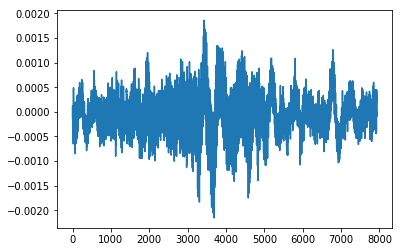

In [12]:

print(np.shape(roi_ACWO))
no = np.random.randint(11)
plt.plot(roi_ACWO[no][0])
ipd.Audio(roi_ACWO[no][0], rate= 22050)
print(roi_ACWO[no][4],'to',roi_ACWO[no][5])

x1 = roi_ACWO[no][2]
x2 = roi_ACWO[no][3]

y1 = abs(int(((roi_ACWO[no][4]/11025)-1) *407))
y2 = abs(int(((roi_ACWO[no][5]/11025)-1) *407))

print(roi_ACWO[no][5]/ roi_ACWO[no][4])

print(y2/y1)


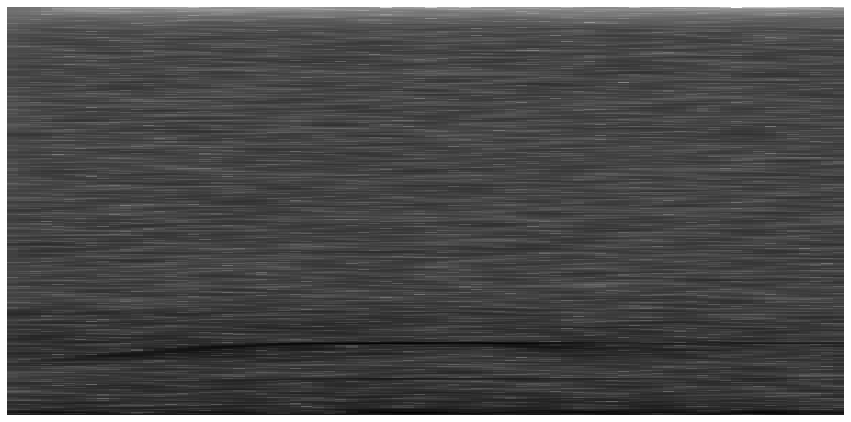

timebins:  74
freqbins:  513


<Figure size 432x288 with 0 Axes>

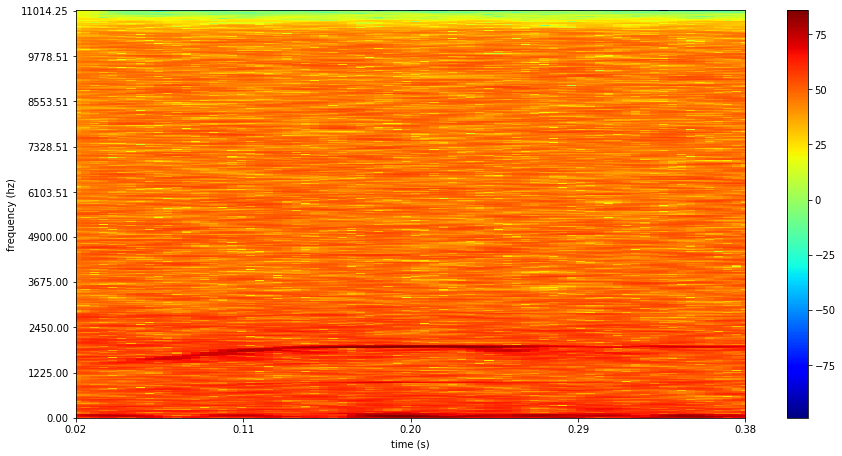

1119.7265625 to 2153.3203125


<Figure size 432x288 with 0 Axes>

In [13]:
pltstft = plotstft(colormap="Greys", srr = 22050, sam = roi_ACWO[no][0])
pltstft = plotstft2(colormap="jet", srr = 22050, sam = roi_ACWO[no][0])

print(roi_ACWO[no][4],'to',roi_ACWO[no][5])
ipd.Audio(roi_ACWO[no][0],rate= 22050)

(407, 837, 3)


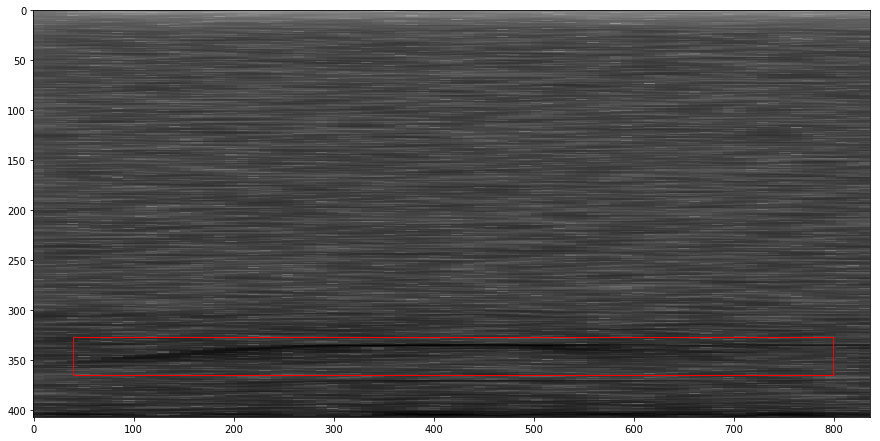

In [14]:
import cv2

img = cv2.imread('test.png')
print(np.shape(img))

cv2.rectangle(img, (40, y1), (800, y2), (255,0,0), 1)
#cv2.rectangle(img,(15,y1),(200,y2),(0,0,255),15)
#font = cv2.FONT_HERSHEY_SIMPLEX
#cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
 
plt.figure(figsize=(15,10))

plt.imshow(img)
plt.show()

In [15]:
print(y2/y1)
y1,y2

0.8958904109589041


(365, 327)

In [16]:
'/media/first/pickled_s2l_2020/Mar30/npy_6/'

'/media/first/pickled_s2l_2020/Mar30/npy_6/'